# Hate Speech Detection on Twitter Data

This notebook performs data mining and discovery on Twitter hate speech data. It includes data exploration, preprocessing, feature extraction, traditional ML classification, clustering, and advanced BERT-based models with MLP and CNN architectures. The goal is to classify tweets into hate speech, offensive language, or neither, while exploring patterns through clustering.

In [1]:
# import subprocess
# import sys

# # Install required packages
# packages = [
#     'pandas',
#     'numpy',
#     'matplotlib',
#     'seaborn',
#     'scikit-learn',
#     'nltk',
#     'torch',
#     'transformers',
#     'tensorflow',
#     'tensorflow-hub',
#     'tensorflow-text',
#     'wordcloud'
# ]

# for package in packages:
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

# print("All dependencies installed successfully!")


# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import html
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import torch
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import tensorflow as tf
from transformers import TFBertForSequenceClassification
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

# Load dataset
file_path = "/content/labeled_dataset.csv"
data = pd.read_csv(file_path)

# Initial exploration
print("Dataset Head:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nClass Distribution:")
print(data['class'].value_counts())

Dataset Head:
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  -----

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Data Preprocessing and Cleaning

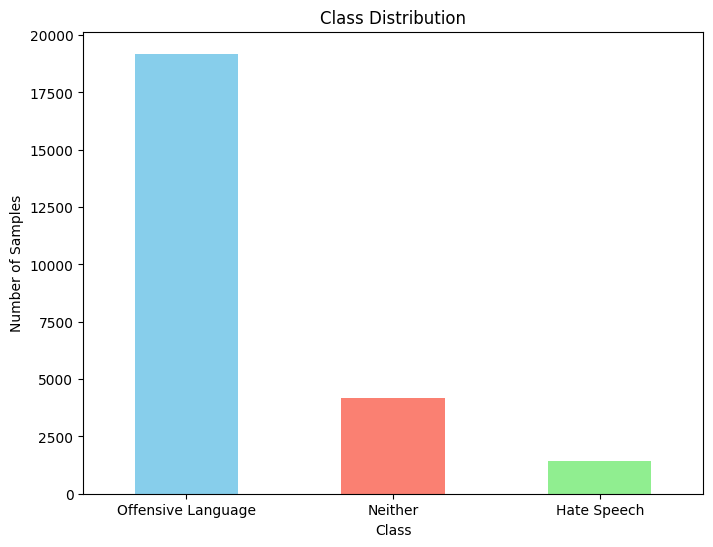

Sample cleaned tweets:
                                               tweet  \
0  !!! RT @mayasolovely: As a woman you shouldn't...   
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...   
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...   
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...   
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...   

                                         clean_tweet  
0  rt woman shouldnt complain cleaning house amp ...  
1  rt boy dats coldtyga dwn bad cuffin dat hoe 1s...  
2  rt dawg rt ever fuck bitch start cry confused ...  
3                                rt look like tranny  
4  rt shit hear might true might faker bitch told...  


In [5]:
# Clean the dataset: drop unnecessary columns and rename
data_cleaned = data.drop(columns=['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])
data_cleaned.rename(columns={'class': 'label'}, inplace=True)

# Map labels to descriptive names
label_mapping = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}
data_cleaned['label_desc'] = data_cleaned['label'].map(label_mapping)

# Visualize class distribution
plt.figure(figsize=(8, 6))
data_cleaned['label_desc'].value_counts().plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.show()

# Define text cleaning function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove emojis and special characters
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols & Pictographs
        u"\U00002600-\U000026FF"  # Misc symbols
        "]+",
        flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return " ".join(filtered_tokens)

# Apply cleaning
data_cleaned['clean_tweet'] = data_cleaned['tweet'].apply(clean_text)

print("Sample cleaned tweets:")
print(data_cleaned[['tweet', 'clean_tweet']].head())

## 3. Feature Extraction with TF-IDF

In [6]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = tfidf.fit_transform(data_cleaned['clean_tweet']).toarray()
y = data_cleaned['label']

print(f"TF-IDF shape: {X_tfidf.shape}")
print(f"Sample features: {tfidf.get_feature_names_out()[:10]}")

TF-IDF shape: (24783, 5000)
Sample features: ['10' '100' '1000' '10000' '1008465039' '100k' '1041204' '10412041041204'
 '104120410412041041204' '1043359']


## 4. Random Forest Classification

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

Random Forest Accuracy: 0.9011498890457939
Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.58      0.13      0.22       286
Offensive Language       0.92      0.96      0.94      3838
           Neither       0.84      0.88      0.86       833

          accuracy                           0.90      4957
         macro avg       0.78      0.66      0.67      4957
      weighted avg       0.89      0.90      0.89      4957



## 5. Handling Class Imbalance with Weights

In [8]:
# Compute class weights
classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))

# Train weighted Random Forest
rf_weighted = RandomForestClassifier(n_estimators=200, class_weight=class_weight_dict, random_state=42)
rf_weighted.fit(X_train, y_train)

# Predict and evaluate
y_pred_weighted = rf_weighted.predict(X_test)
print(f"Weighted Random Forest Accuracy: {accuracy_score(y_test, y_pred_weighted)}")
print("Classification Report:")
print(classification_report(y_test, y_pred_weighted, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

Weighted Random Forest Accuracy: 0.8973169255598143
Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.48      0.19      0.27       286
Offensive Language       0.93      0.95      0.94      3838
           Neither       0.82      0.90      0.86       833

          accuracy                           0.90      4957
         macro avg       0.74      0.68      0.69      4957
      weighted avg       0.88      0.90      0.89      4957



## 6. Text Clustering with K-Means

Silhouette Score: 0.00478998652355373
Davies-Bouldin Score: 10.048030431042084


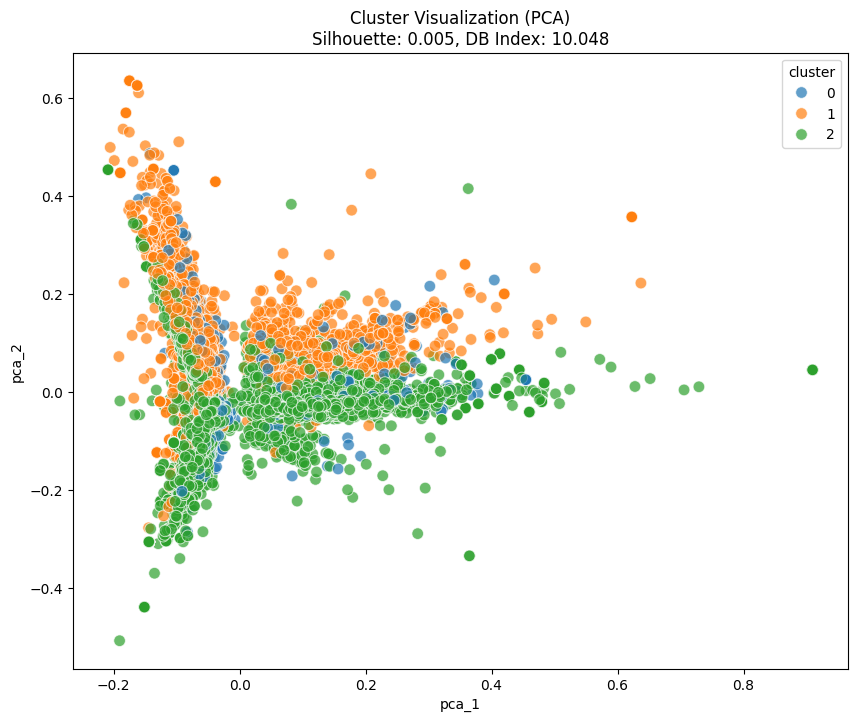

In [9]:
# K-Means Clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Evaluate clusters
sil_score = silhouette_score(X_tfidf, clusters)
db_score = davies_bouldin_score(X_tfidf, clusters)
print(f"Silhouette Score: {sil_score}")
print(f"Davies-Bouldin Score: {db_score}")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf)
data_cleaned['pca_1'] = X_pca[:, 0]
data_cleaned['pca_2'] = X_pca[:, 1]
data_cleaned['cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data_cleaned, x='pca_1', y='pca_2', hue='cluster', palette='tab10', s=70, alpha=0.7)
plt.title(f'Cluster Visualization (PCA)\nSilhouette: {sil_score:.3f}, DB Index: {db_score:.3f}')
plt.show()

## 7. BERT Model Setup and Tokenization

In [10]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Split data for BERT
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    data_cleaned['clean_tweet'], data_cleaned['label'], test_size=0.2, random_state=42, stratify=data_cleaned['label']
)

# Tokenize
def tokenize_data(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=max_len, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

X_train_ids, X_train_masks = tokenize_data(X_train_bert.tolist(), tokenizer)
X_test_ids, X_test_masks = tokenize_data(X_test_bert.tolist(), tokenizer)
y_train_tensor = torch.tensor(y_train_bert.values)
y_test_tensor = torch.tensor(y_test_bert.values)

# Create DataLoaders
train_dataset = TensorDataset(X_train_ids, X_train_masks, y_train_tensor)
test_dataset = TensorDataset(X_test_ids, X_test_masks, y_test_tensor)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 8. BERT Fine-Tuning for Classification

In [11]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=3e-5)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_masks, b_labels = [t.to(device) for t in batch]
        model.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_masks, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_dataloader)}")

# Evaluation
model.eval()
predictions, true_labels = [], []
for batch in test_dataloader:
    b_input_ids, b_masks, b_labels = [t.to(device) for t in batch]
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_masks)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

print(f"BERT Accuracy: {accuracy_score(true_labels, predictions)}")
print(classification_report(true_labels, predictions, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 Loss: 0.30022981128985843
Epoch 2 Loss: 0.21683575381795245
Epoch 3 Loss: 0.16582611679369885
BERT Accuracy: 0.9144643937865644
                    precision    recall  f1-score   support

       Hate Speech       0.53      0.36      0.43       286
Offensive Language       0.94      0.96      0.95      3838
           Neither       0.90      0.88      0.89       833

          accuracy                           0.91      4957
         macro avg       0.79      0.73      0.75      4957
      weighted avg       0.91      0.91      0.91      4957



## 9. BERT with MLP Architecture

In [14]:
# mlp_model.fit(train_ds, epochs=3, validation_data=test_ds)
# loss, acc_mlp = mlp_model.evaluate(test_ds)
# print(f"BERT MLP Accuracy: {acc_mlp}")

# Define BERT with MLP Architecture (using PyTorch for consistency)
import torch.nn as nn

class BERT_MLP(nn.Module):
    def __init__(self, bert_model, num_classes=3):
        super(BERT_MLP, self).__init__()
        self.bert = bert_model.bert  # Use the BERT base from the fine-tuned model
        self.dropout = nn.Dropout(0.3)
        self.mlp1 = nn.Linear(768, 256)  # BERT hidden size is 768
        self.mlp2 = nn.Linear(256, 128)
        self.classifier = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Use pooled output
        x = self.dropout(pooled_output)
        x = self.relu(self.mlp1(x))
        x = self.dropout(x)
        x = self.relu(self.mlp2(x))
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits

# Load the fine-tuned BERT model from earlier (or reload if needed)
mlp_model = BERT_MLP(model)  # model is the fine-tuned BertForSequenceClassification from section 8
mlp_model.to(device)

# Optimizer and scheduler for MLP
optimizer_mlp = AdamW(mlp_model.parameters(), lr=3e-5)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler_mlp = get_linear_schedule_with_warmup(optimizer_mlp, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop for MLP
for epoch in range(epochs):
    mlp_model.train()
    total_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_masks, b_labels = [t.to(device) for t in batch]
        optimizer_mlp.zero_grad()
        logits = mlp_model(b_input_ids, attention_mask=b_masks)
        loss = nn.CrossEntropyLoss()(logits, b_labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mlp_model.parameters(), 1.0)
        optimizer_mlp.step()
        scheduler_mlp.step()
    print(f"MLP Epoch {epoch+1} Loss: {total_loss / len(train_dataloader)}")

# Evaluation for MLP
mlp_model.eval()
predictions_mlp, true_labels_mlp = [], []
for batch in test_dataloader:
    b_input_ids, b_masks, b_labels = [t.to(device) for t in batch]
    with torch.no_grad():
        logits = mlp_model(b_input_ids, attention_mask=b_masks)
    predictions_mlp.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels_mlp.extend(b_labels.cpu().numpy())

acc_mlp = accuracy_score(true_labels_mlp, predictions_mlp)
print(f"BERT MLP Accuracy: {acc_mlp}")
print(classification_report(true_labels_mlp, predictions_mlp, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

MLP Epoch 1 Loss: 0.26840252698729594
MLP Epoch 2 Loss: 0.15528706412822488
MLP Epoch 3 Loss: 0.10544871753607427
BERT MLP Accuracy: 0.9110349001412145
                    precision    recall  f1-score   support

       Hate Speech       0.50      0.39      0.44       286
Offensive Language       0.94      0.96      0.95      3838
           Neither       0.89      0.87      0.88       833

          accuracy                           0.91      4957
         macro avg       0.78      0.74      0.76      4957
      weighted avg       0.91      0.91      0.91      4957



## 10. BERT with CNN Architecture

In [15]:
# Define BERT with CNN Architecture (using PyTorch for consistency)
import torch.nn as nn

class BERT_CNN(nn.Module):
    def __init__(self, bert_model, num_classes=3):
        super(BERT_CNN, self).__init__()
        self.bert = bert_model.bert  # Use the BERT base
        self.conv1d = nn.Conv1d(768, 128, kernel_size=3, padding=1)  # BERT hidden size 768
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # [batch, seq_len, hidden]
        # Transpose for Conv1d: [batch, hidden, seq_len]
        x = last_hidden_state.permute(0, 2, 1)
        x = self.relu(self.conv1d(x))
        x = self.global_max_pool(x).squeeze(-1)  # [batch, 128]
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits

# Load the fine-tuned BERT model
cnn_model = BERT_CNN(model)
cnn_model.to(device)

# Optimizer and scheduler for CNN
optimizer_cnn = AdamW(cnn_model.parameters(), lr=3e-5)
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler_cnn = get_linear_schedule_with_warmup(optimizer_cnn, num_warmup_steps=0, num_training_steps=total_steps)

# Training loop for CNN
for epoch in range(epochs):
    cnn_model.train()
    total_loss = 0
    for batch in train_dataloader:
        b_input_ids, b_masks, b_labels = [t.to(device) for t in batch]
        optimizer_cnn.zero_grad()
        logits = cnn_model(b_input_ids, attention_mask=b_masks)
        loss = nn.CrossEntropyLoss()(logits, b_labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(cnn_model.parameters(), 1.0)
        optimizer_cnn.step()
        scheduler_cnn.step()
    print(f"CNN Epoch {epoch+1} Loss: {total_loss / len(train_dataloader)}")

# Evaluation for CNN
cnn_model.eval()
predictions_cnn, true_labels_cnn = [], []
for batch in test_dataloader:
    b_input_ids, b_masks, b_labels = [t.to(device) for t in batch]
    with torch.no_grad():
        logits = cnn_model(b_input_ids, attention_mask=b_masks)
    predictions_cnn.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels_cnn.extend(b_labels.cpu().numpy())

acc_cnn = accuracy_score(true_labels_cnn, predictions_cnn)
print(f"BERT CNN Accuracy: {acc_cnn}")
print(classification_report(true_labels_cnn, predictions_cnn, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

CNN Epoch 1 Loss: 0.13345499346333164
CNN Epoch 2 Loss: 0.07839801181577176
CNN Epoch 3 Loss: 0.04129298505516002
BERT CNN Accuracy: 0.9045793826911438
                    precision    recall  f1-score   support

       Hate Speech       0.44      0.35      0.39       286
Offensive Language       0.93      0.95      0.94      3838
           Neither       0.89      0.87      0.88       833

          accuracy                           0.90      4957
         macro avg       0.76      0.72      0.74      4957
      weighted avg       0.90      0.90      0.90      4957



## 11. Model Evaluation and Comparison

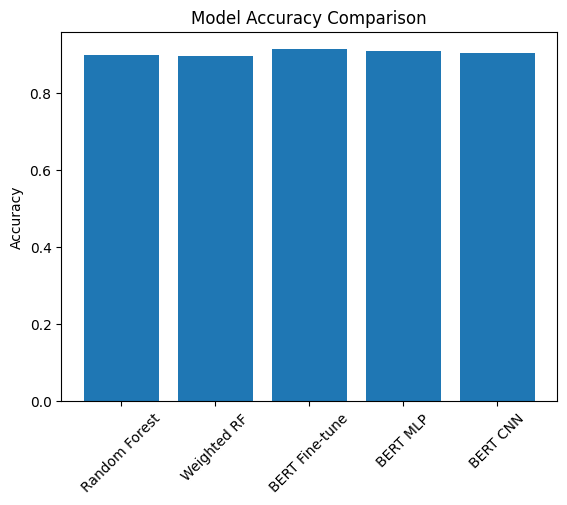

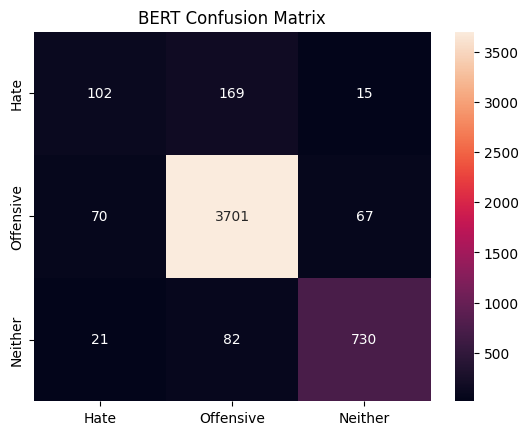

In [16]:
# Compare accuracies
models = ['Random Forest', 'Weighted RF', 'BERT Fine-tune', 'BERT MLP', 'BERT CNN']
accuracies = [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_weighted), accuracy_score(true_labels, predictions), acc_mlp, acc_cnn]

plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# Confusion matrix for best model (BERT)
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Hate', 'Offensive', 'Neither'], yticklabels=['Hate', 'Offensive', 'Neither'])
plt.title('BERT Confusion Matrix')
plt.show()

## 12. Visualization of Results

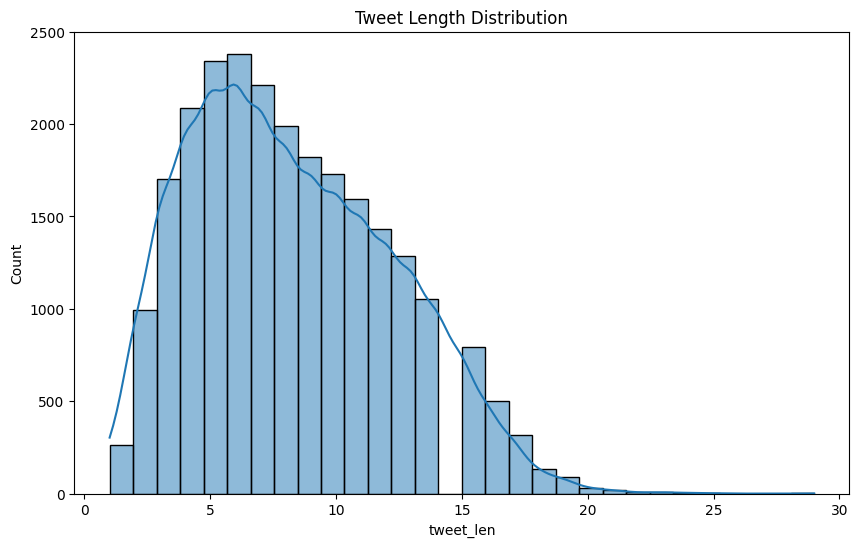

In [17]:
# Additional plots
# Tweet length distribution
data_cleaned['tweet_len'] = data_cleaned['clean_tweet'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data_cleaned['tweet_len'], bins=30, kde=True)
plt.title('Tweet Length Distribution')
plt.show()


In [21]:
# Save models (if needed)
model.save_pretrained('./bert_model')
tokenizer.save_pretrained('./bert_model')

('./bert_model/tokenizer_config.json',
 './bert_model/special_tokens_map.json',
 './bert_model/vocab.txt',
 './bert_model/added_tokens.json')

## 13. Enhancements: Hyperparameter Tuning and Cross-Validation

In [18]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(class_weight=class_weight_dict, random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X_test)
print(f"Tuned RF Accuracy: {accuracy_score(y_test, y_pred_tuned)}")
print(classification_report(y_test, y_pred_tuned, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Tuned RF Accuracy: 0.896913455719185
                    precision    recall  f1-score   support

       Hate Speech       0.46      0.18      0.26       286
Offensive Language       0.93      0.95      0.94      3838
           Neither       0.82      0.90      0.86       833

          accuracy                           0.90      4957
         macro avg       0.74      0.68      0.69      4957
      weighted avg       0.88      0.90      0.89      4957



## 14. Feature Importance and Interpretability

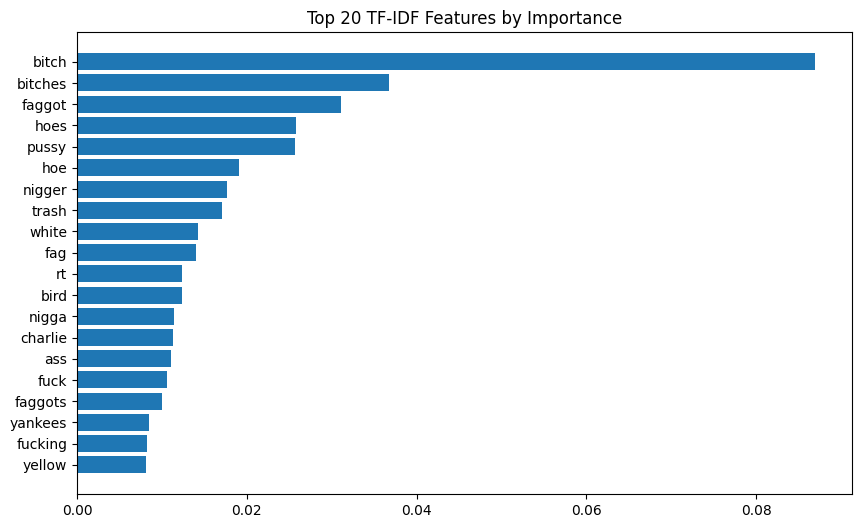

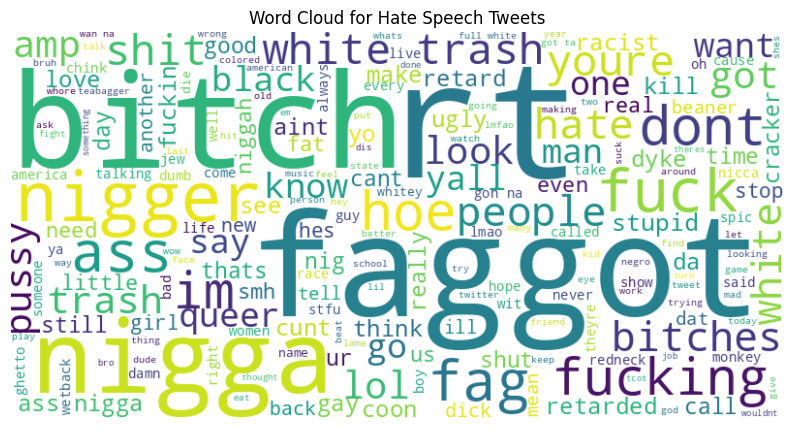

In [19]:
from wordcloud import WordCloud

# Feature importance from Random Forest
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features
features = tfidf.get_feature_names_out()[indices]

plt.figure(figsize=(10, 6))
plt.barh(features, importances[indices])
plt.title('Top 20 TF-IDF Features by Importance')
plt.show()

# Word cloud for hate speech
hate_tweets = data_cleaned[data_cleaned['label'] == 0]['clean_tweet']
hate_text = ' '.join(hate_tweets)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(hate_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Hate Speech Tweets')
plt.show()

## 15. Summary and Insights

In [20]:
# Summary table of results
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Weighted RF', 'Tuned RF', 'BERT Fine-tune', 'BERT MLP', 'BERT CNN'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_weighted), accuracy_score(y_test, y_pred_tuned), accuracy_score(true_labels, predictions), acc_mlp, acc_cnn]
})
print(results_df)

            Model  Accuracy
0   Random Forest  0.901150
1     Weighted RF  0.897317
2        Tuned RF  0.896913
3  BERT Fine-tune  0.914464
4        BERT MLP  0.911035
5        BERT CNN  0.904579
